In [1]:
#import relevant package
import pandas as pd
from fbprophet import Prophet

In [2]:
#import data from sample
df = pd.read_csv('myTrx.csv', thousands=',', parse_dates=['date'], skiprows=1 ,  
                 names=['date','acc_name','description','category','amount_rm','amount'])

df['daysofweek'] = df['date'].dt.weekday
df['days'] = df['date'].dt.weekday_name
df['week'] = df['date'].dt.week

df_group = df.groupby(['week','daysofweek','date'],as_index=False)[['amount']].sum()

df_trx = df_group[['date','amount']][(df_group['week']>=20) & (df_group['week']<=21)]
df_trx.columns = ['ds','y']

In [3]:
#if needed please remove outlier first
df_trx.loc[(df_trx['ds'] == '2013-05-21'), 'y'] = None

In [4]:
#adding holidays into the algorithm
holiday = pd.DataFrame({
  'holiday': 'malaysia_holiday',
  'ds': pd.to_datetime(['2013-05-01', '2013-05-06', '2013-05-24', 
                        '2013-06-01', '2013-06-06']),
  'lower_window': 0,
  'upper_window': 1,
})

In [5]:
#starting to construct the algorithm
m = Prophet(weekly_seasonality=True, holidays=holiday)

m.fit(df_trx)
future = m.make_future_dataframe(periods=7) #extend the date to another 7 days
# future['floor'] = 0

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 8.0.


In [6]:
forecast = m.predict(future) #predict the future consumption

In [7]:
today_spend = 200 # get the value from today spending
today_predict = forecast.set_index('ds', drop = False).loc['2013-05-31','yhat']
percent_used = today_spend / today_predict * 100

if percent_used <= 100:
    print('You have save {:.0f}% today.'.format(100 - percent_used))
else:
    print('OMG, You have exceed spending of {:.0f}% today.'.format(percent_used - 100))

OMG, You have exceed spending of 110% today.


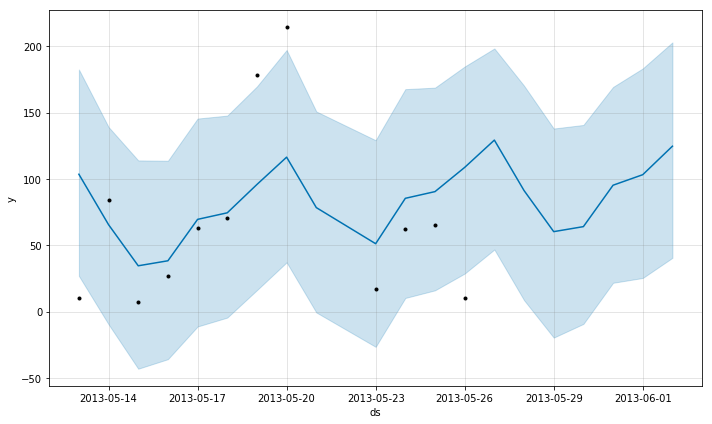

In [8]:
m.plot(forecast)

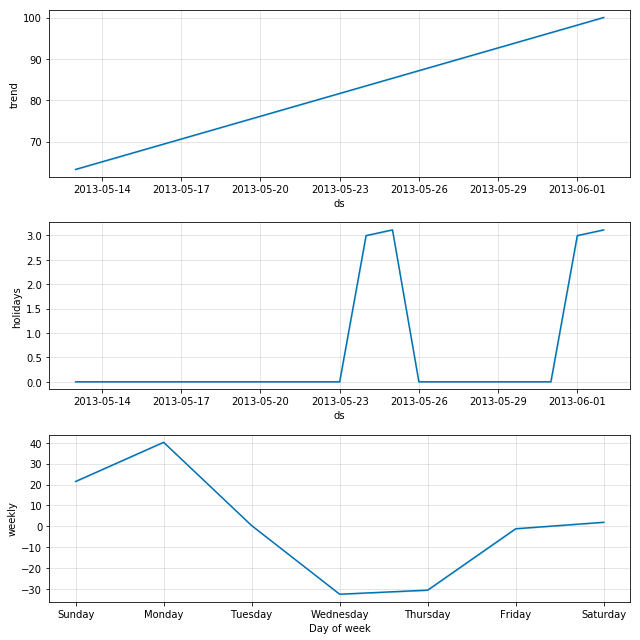

In [9]:
m.plot_components(forecast)

In [10]:
result = pd.merge(df_trx, forecast[['ds','yhat']], how='left', on=['ds'])

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import Imputer

# result2 = Imputer(missing_values="NaN", axis=1).fit_transform(result)
result2 = result.drop([8])

print('result r2: ', r2_score(result2.y, result2.yhat))
print('result MSE: ', mean_squared_error(result2.y, result2.yhat))
print('result MAE: ', mean_absolute_error(result2.y, result2.yhat))
print('result RMSE: ', ((result2.y - result2.yhat) ** 2).mean() ** .5)

result r2:  0.208222233292
result MSE:  3213.46551748
result MAE:  43.600398865
result RMSE:  56.68743703400276
